# TODO

Intro
- EDA (correlation matrix) ; fouskakis 

Dataset
- add more columns from codebook 

Features
- bmi, weight, height, bmi_group -> avoid multicollinearity
- scaler to columns: height, weight, bmi
- correlation matrix to drop highly correlated features, threshold = 0.75
- feature importance analysis 
- one hot encoding to categorical columns

Balance data
- explore ways to balance data
- SMOTE

Model
- explore classifiers
- grid search -> find best 
- model explainability

Extra
- further research -> kaggle notebooks
- counterfactual explanations


Links<br>
https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators<br>
https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset<br>
https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf<br>
https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system/data<br>
https://www.cdc.gov/pcd/issues/2019/19_0109.htm<br>
https://www.kaggle.com/code/alexteboul/diabetes-health-indicators-dataset-notebook<br>

# Info

- Έγιναν drop columns που αφορούσαν ερωτήσεις σε άτομα που ήδη έχουν διαβήτη, καθώς και η στήλη prediabetes.
- Αφαιρέθηκαν τα rows με διαβήτη τύπου 1, ο οποίο είναι αυτοάνοσο νόσημα.<br>
0: no diabetes, or only during pregnancy<br>
1: prediabetes<br>
2: diabetes

# Imports

In [1]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from xgboost import XGBClassifier

In [2]:
path = 'Data/'
RAND_STATE = 42

In [3]:
inputs = pd.read_csv(path + 'diabetes_dataset.csv')

# EDA

# Preprocessing

In [4]:
class preprocessing():
    def __init__(self, raw):
        self.data = raw.copy()
        self.label_name = 'diabetes'
        self.non_categorical = ['sleep_time', 'bmi', 'height', 'weight']
        
    def convert_type(self):
        for col in list(set(self.data.columns) - set(self.non_categorical)):
            self.data[col] = self.data[col].astype('category')
    
    def extract_labels(self):
        self.labels = self.data[[self.label_name]].to_numpy().flatten()
    
    def class_frequencies(self):
        _ , self.class_samples = np.unique(self.labels, return_counts=True)
        self.class_freq = self.class_samples/len(self.data)
#         if as_pct==True:
#             print(self.class_freq)
#         else:
#             print(self.class_samples)
    
    def remove_labels(self):
        self.data.drop([self.label_name], axis=1, inplace=True)
            
    def resample(self, T, num_samples):
        # using Rare Class Sampling
        self.extract_labels()
        self.class_frequencies() 
        probs = np.exp((1 - self.class_freq) / T)
        probs /= probs.sum()
        self.data['sample_weight'] = self.data[self.label_name].map({0: probs[0], 1: probs[1], 2: probs[2]})
        self.data = self.data.sample(n=num_samples, replace=False, weights='sample_weight', random_state=RAND_STATE)
        self.data.drop(['sample_weight'], axis=1, inplace=True)
        
    def remove_cols(self, cols_to_drop):
        self.data.drop(cols_to_drop, axis=1, inplace=True)
        
    def remove_rows(self, column, column_value):
        self.data = self.data[self.data[column]!=column_value] 
        
    def equalize(self):
        N = len(self.data[self.data[self.label_name]==1])
        tmp1 = self.data[self.data[self.label_name]==0].sample(n=N, replace=False, random_state=RAND_STATE)
        tmp2 = self.data[self.data[self.label_name]==1].sample(n=N, replace=False, random_state=RAND_STATE)
        tmp3 = self.data[self.data[self.label_name]==2].sample(n=N, replace=False, random_state=RAND_STATE)
        self.data = pd.concat([tmp1, tmp2, tmp3]).sample(frac=1, random_state = RAND_STATE)
    
    def plot_correlation_matrix(self, include_labels):
        if include_labels:
            self.corr_matrix = self.data.corr()
        else:
            self.corr_matrix = self.data.drop(self.label_name, axis=1).corr()
        mask = np.triu(np.ones_like(self.corr_matrix, dtype=bool))
        plt.figure(figsize=(10, 8))
        sns.heatmap(self.corr_matrix, mask=mask, annot=False, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
        plt.title('Feature Correlation Matrix')
        plt.show()
        
    def onehot(self):
        self.data = pd.get_dummies(self.data, drop_first=True)
        
        
    def preprocessing_pipeline(self, resample, equalize=False, T=0.1, n_samples=50000):
        self.remove_rows(column = 'diabetes_type', column_value = 1)
        self.remove_cols(['diabetes_type','currently_insulin','hemoglobin','eye_exam','eye_photo','diabetes_education',
                         'sore_feet','prediabetes'])
        if resample:
            self.resample(T, n_samples)
        if equalize:
            self.equalize()    
        self.extract_labels()
        self.class_frequencies()
        self.plot_correlation_matrix(include_labels=False)
        self.remove_labels()
        self.convert_type()
        self.onehot()
    

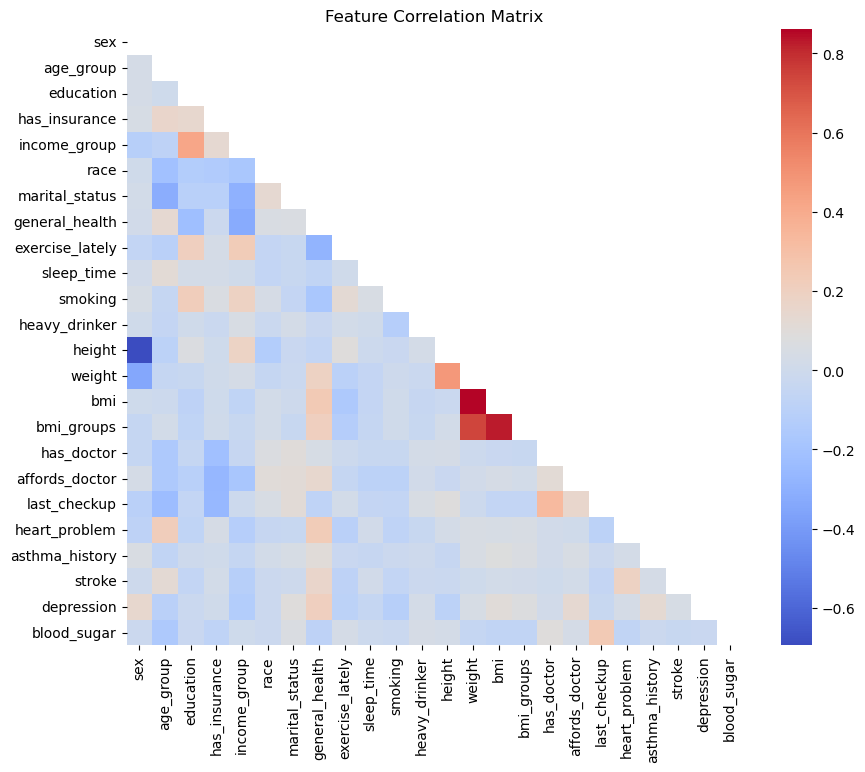

In [5]:
without_resampling = preprocessing(inputs)
without_resampling.preprocessing_pipeline(resample=False)

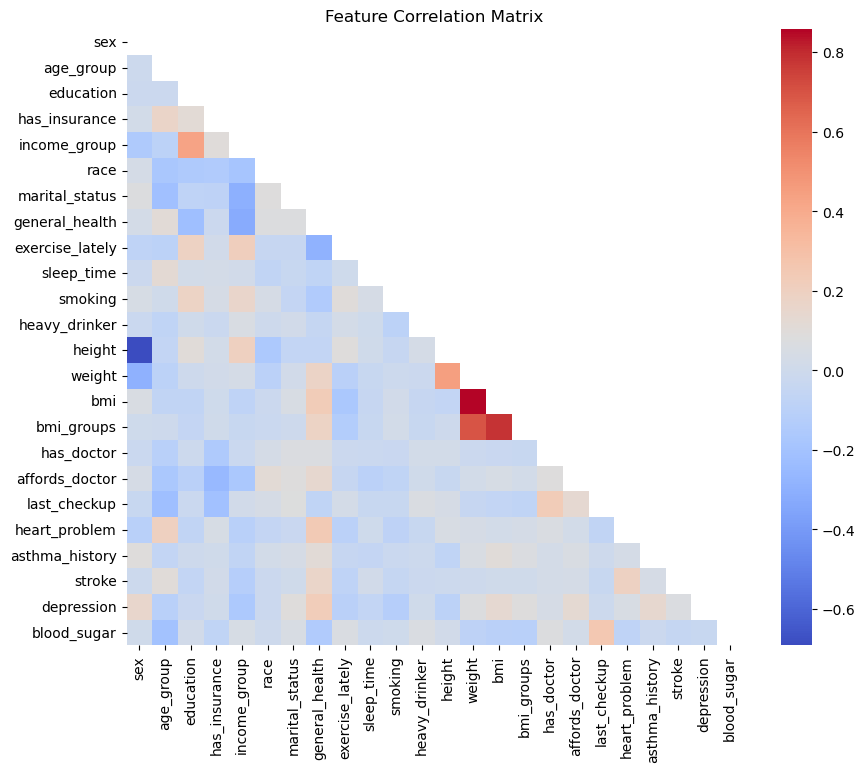

In [6]:
with_resampling = preprocessing(inputs)
with_resampling.preprocessing_pipeline(resample=True, T=0.1, n_samples=50000)

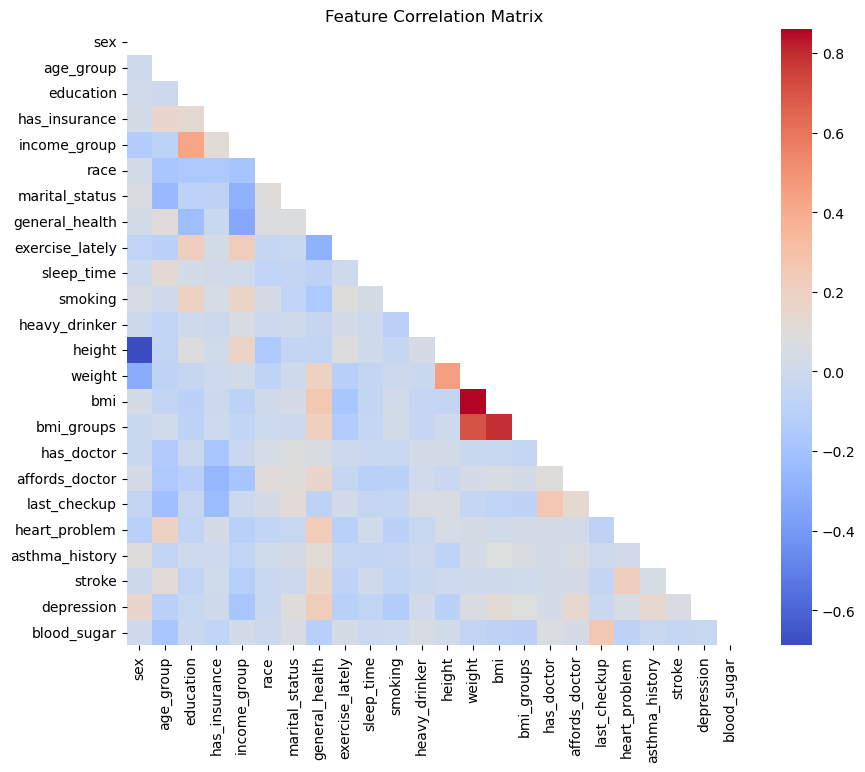

In [7]:
equalized = preprocessing(inputs)
equalized.preprocessing_pipeline(resample=False, equalize = True)

In [8]:
print(f'without_resampling: {without_resampling.class_freq}')
print(f'with_resampling: {with_resampling.class_freq}')
print(f'equal labels: {equalized.class_freq}')

without_resampling: [0.84102052 0.0237988  0.13518068]
with_resampling: [0.23018 0.11524 0.65458]
equal labels: [0.33333333 0.33333333 0.33333333]


In [9]:
without_resampling.data

,sleep_time,height,weight,bmi,sex_1,age_group_1,age_group_2,age_group_3,age_group_4,age_group_5,...,asthma_history_1,asthma_history_2,stroke_1,depression_1,blood_sugar_1,blood_sugar_2,blood_sugar_3,blood_sugar_4,blood_sugar_5,blood_sugar_6
0,6,1.60,68.04,26.57,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,5,1.57,63.50,25.61,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,9,1.57,53.98,21.77,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,7,1.65,62.60,22.96,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,8,1.63,73.48,27.81,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242617,6,1.88,88.45,25.04,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
242618,7,1.68,83.91,29.86,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
242619,8,1.83,104.33,31.19,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
242620,7,1.70,83.01,28.66,True,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False


In [10]:
without_resampling.data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 242113 entries, 0 to 242621
Data columns (total 61 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   sleep_time         242113 non-null  int64  
 1   height             242113 non-null  float64
 2   weight             242113 non-null  float64
 3   bmi                242113 non-null  float64
 4   sex_1              242113 non-null  bool   
 5   age_group_1        242113 non-null  bool   
 6   age_group_2        242113 non-null  bool   
 7   age_group_3        242113 non-null  bool   
 8   age_group_4        242113 non-null  bool   
 9   age_group_5        242113 non-null  bool   
 10  education_1        242113 non-null  bool   
 11  education_2        242113 non-null  bool   
 12  education_3        242113 non-null  bool   
 13  has_insurance_1    242113 non-null  bool   
 14  income_group_1     242113 non-null  bool   
 15  income_group_2     242113 non-null  bool   
 16  income_

# Model training

## Classifiers

In [11]:
class BaseClassifier:
    def __init__(self, data, labels, random_state=42):
        self.random_state = random_state
        self.data = data
        self.labels = labels
        self.model = None

    def run_pipeline(self, report=False, fi=False, cm=False):
        self.create_model()
        self.split(test_size=0.2)
        self.train()
        if report:
            self.generate_classification_report()
        if fi and hasattr(self, 'feature_importance'):
            self.feature_importance()
        if cm:
            self.plot_confusion_matrix()    
    
    def create_model(self):
        raise NotImplementedError("This method should be overridden by subclasses")

    def split(self, test_size=0.2, stratify=True):
        stratify_labels = self.labels if stratify else None
        self.train_data, self.test_data, self.train_labels, self.test_labels = train_test_split(
            self.data, 
            self.labels,
            test_size=test_size,
            random_state=self.random_state,
            stratify=stratify_labels 
        )

    def train(self):
        if self.model is not None:
            self.model.fit(self.train_data, self.train_labels)

    def generate_classification_report(self):
#         if self.model is not None:
        predictions = self.model.predict(self.test_data)
        print(classification_report(self.test_labels, predictions))

    def plot_confusion_matrix(self):
#         if self.model is not None:
        y_pred = self.model.predict(self.test_data)
        cm = confusion_matrix(self.test_labels, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        

In [12]:
class RandomForestModel(BaseClassifier):
    
    def create_model(self):
        self.model = RandomForestClassifier(random_state=self.random_state)

    def feature_importance(self):
        if self.model is not None:
            importance = self.model.feature_importances_
            features = self.train_data.columns

            indices = np.argsort(importance)
            sorted_importance = np.take(importance, indices, axis=0)
            sorted_features = np.take(features, indices, axis=0)

            plt.figure(figsize=(5,5))
            plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
            plt.yticks(range(len(sorted_importance)), sorted_features)
            plt.xlabel('Feature Importance')
            plt.ylabel('Feature')
            plt.show()


In [13]:
class XGBoostModel(BaseClassifier):
    
    def create_model(self):
        self.model = XGBClassifier(class_weight = {0:1, 1:2, 2:1.5},
                                   random_state=self.random_state)

    def feature_importance(self):
        if self.model is not None:
            importance = self.model.feature_importances_
            features = self.train_data.columns

            indices = np.argsort(importance)
            sorted_importance = np.take(importance, indices, axis=0)
            sorted_features = np.take(features, indices, axis=0)

            plt.figure(figsize=(6, 6))
            plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
            plt.yticks(range(len(sorted_importance)), sorted_features)
            plt.xlabel('Feature Importance')
            plt.ylabel('Feature')
            plt.show()


In [14]:
class LogisticRegressionModel(BaseClassifier):
    
    def create_model(self):
        self.model = LogisticRegression(random_state=self.random_state)

In [15]:
class BalancedRandomForestModel(BaseClassifier):
    
    def create_model(self):
        self.model = BalancedRandomForestClassifier(random_state=self.random_state)

    def feature_importance(self):
        if self.model is not None:
            importance = self.model.feature_importances_
            features = self.train_data.columns

            indices = np.argsort(importance)
            sorted_importance = np.take(importance, indices, axis=0)
            sorted_features = np.take(features, indices, axis=0)

            plt.figure(figsize=(5,5))
            plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
            plt.yticks(range(len(sorted_importance)), sorted_features)
            plt.xlabel('Feature Importance')
            plt.ylabel('Feature')
            plt.show()

## Implementations

In [16]:
print('Implementing random forest on dataset without resampling...')
rf1 = RandomForestModel(without_resampling.data, without_resampling.labels)
rf1.run_pipeline(report=True)

Implementing random forest on dataset without resampling...
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     40725
           1       0.00      0.00      0.00      1152
           2       0.56      0.28      0.37      6546

    accuracy                           0.85     48423
   macro avg       0.48      0.42      0.43     48423
weighted avg       0.81      0.85      0.82     48423



In [18]:
print('Implementing random forest on dataset without resampling...')
brf1 = BalancedRandomForestModel(without_resampling.data, without_resampling.labels)
brf1.run_pipeline(report=True)

Implementing random forest on dataset without resampling...


C:\Users\milio\anaconda3\envs\edemm\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\milio\anaconda3\envs\edemm\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\milio\anaconda3\envs\edemm\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future 

              precision    recall  f1-score   support

           0       0.96      0.59      0.73     40725
           1       0.04      0.38      0.08      1152
           2       0.37      0.77      0.50      6546

    accuracy                           0.61     48423
   macro avg       0.46      0.58      0.44     48423
weighted avg       0.86      0.61      0.68     48423



In [19]:
print('Implementing random forest on dataset with resampling...')
rf2 = RandomForestModel(with_resampling.data, with_resampling.labels)
rf2.run_pipeline(report=True)

Implementing random forest on dataset with resampling...
              precision    recall  f1-score   support

           0       0.67      0.57      0.62      2302
           1       0.55      0.13      0.21      1152
           2       0.81      0.96      0.88      6546

    accuracy                           0.77     10000
   macro avg       0.68      0.55      0.57     10000
weighted avg       0.75      0.77      0.74     10000



In [20]:
print('Implementing random forest on dataset with resampling...')
brf2 = BalancedRandomForestModel(with_resampling.data, with_resampling.labels)
brf2.run_pipeline(report=True)

Implementing random forest on dataset with resampling...


C:\Users\milio\anaconda3\envs\edemm\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\milio\anaconda3\envs\edemm\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\milio\anaconda3\envs\edemm\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future 

              precision    recall  f1-score   support

           0       0.56      0.60      0.58      2302
           1       0.25      0.38      0.30      1152
           2       0.85      0.75      0.80      6546

    accuracy                           0.67     10000
   macro avg       0.55      0.58      0.56     10000
weighted avg       0.71      0.67      0.69     10000



In [21]:
print('Implementing random forest on dataset with equalized labels...')
rf3 = RandomForestModel(equalized.data, equalized.labels)
rf3.run_pipeline(report=True)

Implementing random forest on dataset with equalized labels...
              precision    recall  f1-score   support

           0       0.63      0.60      0.61      1152
           1       0.54      0.40      0.46      1153
           2       0.58      0.76      0.66      1153

    accuracy                           0.59      3458
   macro avg       0.58      0.59      0.58      3458
weighted avg       0.58      0.59      0.58      3458



In [22]:
print('Implementing random forest on dataset with equalized labels...')
brf3 = BalancedRandomForestModel(equalized.data, equalized.labels)
brf3.run_pipeline(report=True)

Implementing random forest on dataset with equalized labels...


C:\Users\milio\anaconda3\envs\edemm\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\milio\anaconda3\envs\edemm\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\milio\anaconda3\envs\edemm\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future 

              precision    recall  f1-score   support

           0       0.62      0.58      0.60      1152
           1       0.54      0.40      0.46      1153
           2       0.57      0.77      0.66      1153

    accuracy                           0.58      3458
   macro avg       0.58      0.58      0.57      3458
weighted avg       0.58      0.58      0.57      3458



In [18]:
# print('Implementing XGBoost on dataset without resampling...')
# xgb1 = XGBoostModel(without_resampling.data, without_resampling.labels)
# xgb1.run_pipeline(report=True, fi=True, cm=True)

# print('Implementing XGBoost on dataset with resampling...')
# xgb2 = XGBoostModel(with_resampling.data, with_resampling.labels)
# xgb2.run_pipeline(report=True, fi=True, cm=True)

# print('Implementing XGBoost on dataset with equalized labels...')
# xgb3 = XGBoostModel(equalized.data, equalized.labels)
# xgb3.run_pipeline(report=True, fi=True, cm=True)

In [19]:
# print('Implementing logistic regression on dataset without resampling...')
# lr1 = LogisticRegressionModel(without_resampling.data, without_resampling.labels)
# lr1.run_pipeline(report=True, fi=False, cm=True)

# print('Implementing logistic regression on dataset without resampling...')
# lr2 = LogisticRegressionModel(with_resampling.data, with_resampling.labels)
# lr2.run_pipeline(report=True, fi=False, cm=True)

# print('Implementing logistic regression on dataset with equalized labels...')
# lr3 = LogisticRegressionModel(equalized.data, equalized.labels)
# lr3.run_pipeline(report=True, fi=False, cm=True)


In [31]:
without_resampling.class_freq

array([0.84102052, 0.0237988 , 0.13518068])

In [21]:
inputs['diabetes'].value_counts()

diabetes
0    203622
2     33238
1      5762
Name: count, dtype: int64